# 6. SASA alignment

We are using relative SASA values.

---

## Setup

In [1]:
import sys; sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import bin.params as p
import bin.utils as u

sns.set_theme()

In [73]:
# old
SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unaligned'
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned'
SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_aligned'

# July 2024
SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unalignedJuly2024'
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024'
SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_alignedJuly2024'

# IB July 2024
SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unalignedJuly2024'
#FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedIBJuly2024'
SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_alignedIBJuly2024' 

# IB July 2 2024
SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unalignedIB2July2024'
#FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedIB2July2024'
SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_alignedIB2July2024' 

# Fixing high-MAE
#SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unaligned_fixbug'
#FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned_fixbug'
#SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_aligned_fixbug'

# July 2024
SASA_RELATIVE_UNALIGNED_CSV_DIR = f'{p.DATA_DIR}/csv/sasa_relative_unalignedJuly2024'
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024'
SASA_ALIGNED_DIR_PATH = f'{p.DATA_DIR}/csv/sasa_alignedJuly2024'

SASA_RELATIVE_UNALIGNED_CSV_DIR, FASTA_ALIGNED_CLEANED_DIR_PATH, SASA_ALIGNED_DIR_PATH

('../../data/csv/sasa_relative_unalignedJuly2024',
 '../../data/csv/fasta_aligned_cleanedJuly2024',
 '../../data/csv/sasa_alignedJuly2024')

In [74]:
sasa_unaligned = pd.read_csv(f'{SASA_RELATIVE_UNALIGNED_CSV_DIR}/sasa_all.csv', index_col=0)
print('sasa_unaligned.shape:', sasa_unaligned.shape, '| mean sasa values count:', sasa_unaligned.count(axis=1).mean().round(2))
sasa_unaligned.head(n=1)

sasa_unaligned.shape: (1776, 595) | mean sasa values count: 172.35


,0,1,2,3,4,5,6,7,8,9,...,585,586,587,588,589,590,591,592,593,594
7DF1:H,62.1,74.7,0.0,55.9,0.0,29.8,NaN,69.3,30.9,82.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
fasta_aligned = dict(
    L = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv', index_col=0),
    H = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv', index_col=0),
)
print('fasta_aligned_cleaned_dir_path:', FASTA_ALIGNED_CLEANED_DIR_PATH)
print('fasta_aligned_L.shape', fasta_aligned['L'].shape, 'fasta_aligned_H.shape', fasta_aligned['H'].shape)
print('mean number of aligned fasta non-vacant residues per chain | L:', u.nondash_counts(fasta_aligned['L']).mean(),
      'H:', u.nondash_counts(fasta_aligned['H']).mean().round(2))
fasta_aligned['L'].head(n=2)

fasta_aligned_cleaned_dir_path: ../../data/csv/fasta_aligned_cleanedJuly2024
fasta_aligned_L.shape (888, 150) fasta_aligned_H.shape (888, 162)
mean number of aligned fasta non-vacant residues per chain | L: 108.68018018018019 H: 121.24


,1,2,3,4,5,6,7,8,9,10,...,140,141,142,143,144,145,146,147,148,149
Id,,,,,,,,,,,,,,,,,,,,,
7DF1:L,D,I,V,M,T,Q,S,P,D,S,...,G,Q,G,T,R,L,E,I,-,-
7E9O:L,D,I,V,M,T,Q,S,P,L,S,...,G,P,G,T,K,V,D,I,K,R


In [76]:
command = f'mkdir -p {SASA_ALIGNED_DIR_PATH}'
print(SASA_ALIGNED_DIR_PATH)
! $command

../../data/csv/sasa_alignedJuly2024


---

## SASA2FASTA Alignment

The algorithm we use here is fairly simple, but probably not too optimal.

**TODO? Try some other ones? Parametrize for the choice of algorithm?**

In [77]:
def align_sasa(fasta: pd.DataFrame, sasa_unaligned: pd.DataFrame, bad_columns: list = []) -> dict:
    aligned_sasa_chain = dict()
    for row_index, row in fasta.iterrows():
        new_row = []
        #sasa_row = iter(sasa_unaligned.loc[row_index].dropna())
        sasa_row = iter(sasa_unaligned.loc[row_index])
        #print(len(row.items()
        try:
            for aa_index, aa in row.items():
                #print(aa_index)
                if aa == '-': 
                    #print('adding nan')
                    new_row.append(np.nan)
                else:
                    val = next(sasa_row)
                    if aa_index not in bad_columns:
                        # ignore bad position causing the shift
                        #print('adding', val)
                        new_row.append(val)
                    
        except StopIteration:
            pass

        aligned_sasa_chain[row_index] = new_row
        
    return aligned_sasa_chain

**Align chains individually, creating one dataframe per chain:**

In [78]:
chain_dfs = []

for chain in ['L', 'H']:
    chain_dict = align_sasa(fasta_aligned[chain], sasa_unaligned)
    #print(len(chain_dict['7DF1:L']))
    print('chain', chain, 'no-of-chain-dict-values', len(chain_dict.values()), 
          'no-of-chain-dict-keys', len(chain_dict.keys()),
          'len-columns', len(fasta_aligned[chain].columns))
    chain_df = pd.DataFrame(chain_dict.values(), index=chain_dict.keys(),
                            columns=fasta_aligned[chain].columns).sort_index()
    chain_df.to_csv(f'{SASA_ALIGNED_DIR_PATH}/sasa_{chain}.csv')
    chain_dfs.append(chain_df)

chain L no-of-chain-dict-values 888 no-of-chain-dict-keys 888 len-columns 150
chain H no-of-chain-dict-values 888 no-of-chain-dict-keys 888 len-columns 162


In [79]:
chain_dfs[0].head(n=1)

,1,2,3,4,5,6,7,8,9,10,...,140,141,142,143,144,145,146,147,148,149
7DF1:L,74.7,3.9,78.1,0.0,75.8,0.0,78.1,41.7,87.4,73.2,...,NaN,39.3,NaN,0.0,67.8,0.0,69.0,46.0,NaN,NaN


In [80]:
chain_dfs[1].head(n=1)

,1,2,3,4,5,6,7,8,9,10,...,140,141,142,143,144,145,146,147,148,149
7DF1:H,NaN,62.1,74.7,0.0,55.9,0.0,29.8,NaN,NaN,69.3,...,NaN,56.1,NaN,0.0,49.1,0.1,56.1,0.0,56.9,NaN


----

### BUG INVESTIGATION

In [7]:
f = fasta_aligned['H']
s = sasa_unaligned
f = f.loc[['7DF1:H']]
s = s.loc[['7DF1:H']]
print(list(fasta_aligned['H'].columns))
print(f)
print(align_sasa(f, s))

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '36A', '36B', '36C', '36D', '36E', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '63A', '63B', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '85A', '85B', '85C', '85D', '85E', '85F', '85G', '85H', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '123A', '123B', '123C', '123D', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139

In [81]:
chain_dfs[1]['49'].mean()

76.11619047619048

In [61]:
def get_df(fasta_dir, sasa_dir):
    CHAIN_USED = 'H'
    fasta_aligned = dict(
        L = pd.read_csv(f'{fasta_dir}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv', index_col=0),
        H = pd.read_csv(f'{fasta_dir}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv', index_col=0),
    )
    # experiment: '36A', '36B', '36C', '36D', '36E' (removal)
    bad_columns = []
    #if 'fixbug' in fasta_dir:
    #    print('fixbug')
    #    bad_columns = ['36A', '36B', '36C', '36D', '36E']
    #    fasta_aligned[CHAIN_USED] = fasta_aligned[CHAIN_USED].drop(columns=bad_columns)
        
    sasa_unaligned = pd.read_csv(f'{sasa_dir}/sasa_all.csv', index_col=0)
    chd = align_sasa(fasta_aligned[CHAIN_USED], sasa_unaligned, bad_columns)
    chc = pd.DataFrame(chd.values(), index=chd.keys(), columns=fasta_aligned[CHAIN_USED].columns)
    return chc

In [62]:
classic_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleaned',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_relative_unaligned')
new_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleaned_fixbug',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_relative_unaligned_fixbug')
print(classic_df.shape, new_df.shape)
roman_fasta_df = pd.read_csv(f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024/fasta_aho_H.csv', index_col=0)
roman_sasa_df = new_df.loc[roman_fasta_df.index]
mean_diff = (classic_df.mean(axis=0)-roman_sasa_df.mean(axis=0)).abs().mean()
print('mean diff', mean_diff)
u.show_unique_columns(roman_fasta_df, classic_df)

(3286, 164) (4142, 169)
mean diff 8.387571942763724


{'H_yes_old_no_new': ['123C', '143A', '123A', '85H', '123B', '63B', '123D'],
 'H_no_old_yes_new': (['36A', '36D', '36C', '36B', '36E'],)}

4.587773128208592

In [20]:
def plot_means_sequences(classic_df, new_df, start, end):
    means_c, means_n = classic_df.mean(axis=0)[start:end], new_df.mean(axis=0)[start:end]
    plt.figure(figsize=(14, 2))
    plt.plot(means_c, label='classic', marker='o')
    plt.plot(means_n, label='new', marker='s')
    ax = plt.gca()
    n = 5
    labels = ax.get_xticklabels()
    for i, t in enumerate(labels):
        if (i % n) != 0:
            t.set_visible(False)
        t.set_rotation(90)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Two Series Line Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

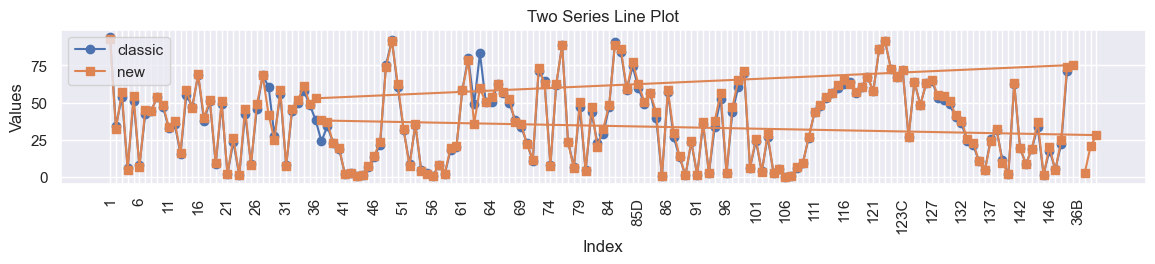

In [63]:
plot_means_sequences(classic_df, new_df, 0, 666)

In [30]:
roman_fasta_df = pd.read_csv(f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024/fasta_aho_H.csv', index_col=0)
roman_sasa_df = new_df.loc[roman_fasta_df.index]
#plot_means_sequences(classic_df, new_df, 0, 666)

#diff_r = (classic_df.mean(axis=0)-new_df_r.mean(axis=0))
#diff_r.abs().mean()
#new_df = new_df_r
roman_sasa_df.head(n=1)

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,143A,144,145,146,147,148,149
Id,,,,,,,,,,,,,,,,,,,,,
7DF1:H,NaN,62.1,74.7,0.0,55.9,0.0,29.8,NaN,69.3,30.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
ser = roman_sasa_df.mean(axis=0).round(2)
roman_means = [(k, v) for k, v in ser.items()]
roman_means
#print(roman_means)

[('1', 85.59),
 ('2', 26.09),
 ('3', 67.53),
 ('4', 1.65),
 ('5', 65.4),
 ('6', 1.98),
 ('7', 54.73),
 ('8', nan),
 ('9', 50.39),
 ('10', 28.33),
 ('11', 53.44),
 ('12', 40.15),
 ('13', 60.08),
 ('14', 44.43),
 ('15', 47.84),
 ('16', 37.05),
 ('17', 16.94),
 ('18', 34.68),
 ('19', 23.38),
 ('20', 28.92),
 ('21', 22.01),
 ('22', 39.56),
 ('23', 27.84),
 ('24', 40.12),
 ('25', 32.04),
 ('26', 53.47),
 ('27', 28.1),
 ('28', 63.87),
 ('29', 38.17),
 ('30', 30.74),
 ('31', 16.43),
 ('32', 11.96),
 ('33', 4.26),
 ('34', 10.33),
 ('35', 2.05),
 ('36', 20.6),
 ('37', 14.18),
 ('38', 4.26),
 ('39', 4.76),
 ('40', 8.93),
 ('41', 17.82),
 ('42', 33.34),
 ('43', 41.69),
 ('44', 35.36),
 ('45', 48.92),
 ('46', 30.86),
 ('47', 14.39),
 ('48', 12.63),
 ('49', 9.88),
 ('50', 8.4),
 ('51', 15.7),
 ('52', 24.03),
 ('53', 36.67),
 ('54', 43.05),
 ('55', 49.33),
 ('56', 45.66),
 ('57', 40.68),
 ('58', 39.13),
 ('59', 31.64),
 ('60', 41.81),
 ('61', 48.55),
 ('62', 33.67),
 ('63', 18.0),
 ('63A', 19.38),
 

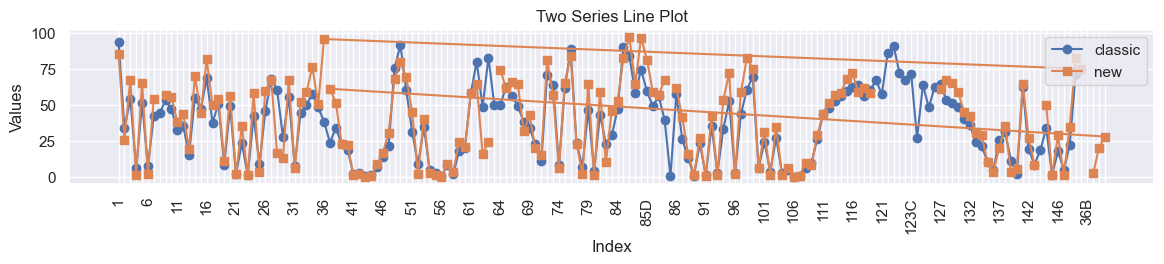

In [64]:
plot_means_sequences(classic_df, roman_sasa_df, 0, 300)

In [18]:
u.show_unique_columns(roman_df, classic_df)

{'H_yes_old_no_new': ['123C', '143A', '123A', '85H', '123B', '63B', '123D'],
 'H_no_old_yes_new': (['36A', '36D', '36C', '36B', '36E'],)}

In [ ]:
classic_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleaned',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_aligned')
new_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleaned_fixbug',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_aligned_fixbug')

In [ ]:
classic_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleaned',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_relative_unaligned')
new_df = get_df(fasta_dir=f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024',
                    sasa_dir=f'{p.DATA_DIR}/csv/sasa_relative_unalignedJuly2024')

<Axes: >

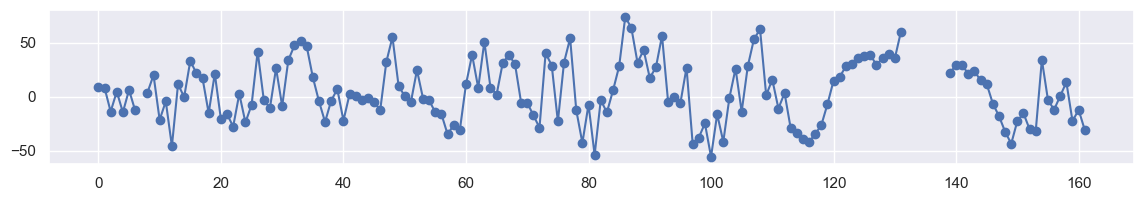

In [114]:
start, end = 0, 200
diffs = classic_df.mean(axis=0)[start:end] -  new_df.mean(axis=0)[start:end]
diffs.plot(label='Series 1', marker='o', figsize=(14, 2), grid=True)

In [ ]:

means = classic_df.mean(axis=0)[start:end], new_df.mean(axis=0)[start:end]
plt.figure(figsize=(14, 2))
plt.plot(means_c, label='Series 1', marker='o')
plt.plot(means_n, label='Series 2', marker='s')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Two Series Line Plot')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
classic_df['49'].mean(), new_df['49'].mean()

(91.89875, 74.29736460348163)

In [13]:
seqs = ['7QU1:H', '7QU1:L', '7QU2:H', '7QU2:L', '7R40:H', '7R40:L', '7S5P:H', '7S5P:L', '7S5Q:H', '7S5Q:L', '7S5R:H', '7S5R:L', '7TE4:H', '7TE4:L', '7TLY:H', '7TLY:L', '7TN0:H', '7TN0:L', '7TOW:H', '7TOW:L', '7TP3:H', '7TP3:L', '7TP4:H', '7TP4:L', '7TQA:H', '7TQA:L', '7TTM:H', '7TTM:L', '7TTX:H', '7TTX:L', '7TUY:H', '7TUY:L', '7U2D:H', '7U2D:L', '7U2E:H', '7U2E:L', '7UAP:H', '7UAP:L', '7URQ:H', '7URQ:L', '7URS:H', '7URS:L', '7WKX:H', '7WKX:L', '7WLZ:H', '7WLZ:L', '7WPE:H', '7WPE:L', '7WPF:H', '7WPF:L', '7WPH:H', '7WPH:L', '7WPV:H', '7WPV:L', '7WRV:H', '7WRV:L', '7X08:H', '7X08:L', '7X9E:H', '7X9E:L', '7Z0X:H', '7Z0X:L', '7Z0Y:H', '7Z0Y:L']
sasa_unaligned_old = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_relative_unaligned/sasa_all.csv', index_col=0).loc[seqs]
sasa_unaligned_new = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_relative_unaligned_fixbug/sasa_all.csv', index_col=0).loc[seqs]
sasa_means_old = sasa_unaligned_old.mean(axis=0)
sasa_means_new = sasa_unaligned_new.mean(axis=0)
diffs = sasa_means_old-sasa_means_new
diffs.index = [int(x) for x in diffs.index]
diffs.sort_index().abs().mean()
#diffs.describe()

            0     1     2     3     4     5     6     7     8     9  ...  585  \
7QU1:H  100.0  19.9  49.0   5.1  51.2   2.3  30.3  67.1  49.2  33.0  ...  NaN   
7QU1:L   74.7   2.9  67.5   3.3  32.5   7.2  72.0  41.2  72.2  55.3  ...  NaN   
7QU2:H   25.4  55.0   5.3  45.0  33.2  59.6  73.6  87.1  50.8  28.7  ...  NaN   
7QU2:L   89.9   2.5  46.4   0.1  43.3   7.1  77.7  55.5  62.0  47.6  ...  NaN   
7R40:H   47.8  97.1  55.7  26.4  38.8  51.4  17.7  44.0  60.2  26.5  ...  NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...   
7X9E:L  100.0   3.5  64.5   9.9  38.9  44.4  36.1  24.8  29.1  12.7  ...  NaN   
7Z0X:H  100.0  57.9  57.5   1.6  42.7   3.1  48.9  51.5  38.8  31.2  ...  NaN   
7Z0X:L  100.0  59.1  51.5   0.0  59.6   8.8  33.7  78.0  65.9  17.7  ...  NaN   
7Z0Y:H   71.1  54.7   2.8  45.2   8.8  48.6  51.5  43.6  41.3  73.4  ...  NaN   
7Z0Y:L  100.0  65.4   1.3  65.2   7.6  32.5  62.0  41.2  16.3  36.6  ...  NaN   

        586  587  588  589 

0.0

In [135]:
sasa_aligned_new = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_alignedJuly2024/sasa_H.csv', index_col=0)
sasa_aligned_old = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_aligned/sasa_H.csv', index_col=0)
sasa_means_old = sasa_aligned_old.mean(axis=0)
sasa_means_new = sasa_aligned_new.mean(axis=0)
diffs = sasa_means_old-sasa_means_new
diffs.index = [u.anarci_column_sorter(x) for x in diffs.index]
diffs.sort_index().abs().mean()

24.958912814965313

In [76]:
sasas = list(sasa_unaligned_old.loc['12E8:H'])
sasas_unaligned_old_H = u.select_only_chain_sequences(sasa_unaligned_old, 'H')
sasas_unaligned_old_H['41']
#sasas.index(98.7)select_only_chain_sequences
#sasas[41]
#sasa_unaligned_old.loc['12E8:H'] 

12E8:H     98.7
15C8:H    100.0
1A0Q:H     28.4
1A14:H     88.1
1A2Y:H    100.0
          ...  
7X08:H     20.7
7X9E:H      5.4
7Z0X:H    100.0
7Z0Y:H     69.4
8FAB:H     65.9
Name: 41, Length: 3286, dtype: float64

In [ ]:
sasa_unaligned_old = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_relative_unaligned/sasa_all.csv', index_col=0)